In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import random
import tqdm
import matplotlib.pyplot as plt

In [2]:
from PIL import Image

In [3]:
pano_directory = '/home/mendeza/Documents/data2/pano_image'
labels_directory = '/home/mendeza/Documents/data2/labels'
dataset_csv = '/home/mendeza/Documents/dataset_10_31_2020_3903_clustered.csv'
df = pd.read_csv('/home/mendeza/Documents/dataset_10_31_2020_3903_clustered.csv')

In [4]:
def get_image(path,IMG_WIDTH=255,IMG_HEIGHT=255,IMG_CHANNELS=3):
    '''
    '''
    img = Image.open(path)
    img = img.resize((IMG_WIDTH,IMG_HEIGHT))
    return img

def get_mask(path,IMG_WIDTH=255,IMG_HEIGHT=255):
    '''
    '''
    img = Image.open(path)
    img = img.resize((IMG_WIDTH,IMG_HEIGHT))
    img = np.array(img)/255.
    img = np.expand_dims(img[:,:,0],axis=-1)

    return img
def get_images(dataset,n_samples=16,shuffle=True):
    '''
    '''
    set = random.sample(dataset,n_samples)
    return set

In [5]:
class DataGenerator(object):
    def __init__(self,
                 dataset_csv,
                 pano_directory,
                 label_directory,
                 num_classes,
                 num_samples_per_class,
                 num_meta_test_classes,
                 num_meta_test_samples_per_class,
                 IMG_WIDTH=255,
                 IMG_HEIGHT=255,
                 num_circles=3):
        '''
        '''
        self.num_samples_per_class = num_samples_per_class
        self.num_classes = num_classes
        self.num_meta_test_samples_per_class = num_meta_test_samples_per_class
        self.num_meta_test_classes = num_meta_test_classes
        self.dataset_csv = dataset_csv
        self.num_circles=num_circles
        self.dataset_df = pd.read_csv(self.dataset_csv)
        # limit the dataset to only contain examples with N num_circles
        self.dataset_df = df[df['num_circles']==self.num_circles-1]# zero index
        self.pano_directory = pano_directory
        self.label_directory = label_directory
        
        self.IMG_WIDTH=IMG_WIDTH
        self.IMG_HEIGHT=IMG_HEIGHT
        data_ids = [os.path.join(pano_directory,i) for i in df['pano_name'].tolist()]
        label_ids =  [os.path.join(labels_directory,i) for i in df['label_name'].tolist()]
        self.dataset = list(zip(data_ids,label_ids))

        self.NUM = len(self.dataset)
        self.train_split = 0.8
        self.val_split = 0.1
        self.test_split = 0.1

        self.num_train = int(self.train_split*self.NUM)
        self.num_val = int(self.val_split*self.NUM)
        self.num_test = int(self.test_split*self.NUM)
        # print(NUM,num_train,num_val,num_test)
        random.seed(123)
        random.shuffle(self.dataset)
        self.train_dataset = self.dataset[:self.num_train]
        self.val_dataset = self.dataset[self.num_train:self.num_train+self.num_val]
        self.test_dataset = self.dataset[self.num_train+self.num_val+1:]

    def sample_batch(self,batch_type,batch_size,shuffle=True,swap=False):
        if batch_type =='meta_train':
            folders = self.train_dataset
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        elif batch_type == 'meta_val':
            folders = self.val_dataset
            num_classes = self.num_classes
            num_samples_per_class = self.num_samples_per_class
        else:
            folders = self.test_dataset
            num_classes = self.num_meta_test_classes
            num_samples_per_class = self.num_meta_test_samples_per_class

        all_image_batches = []
        all_label_batches = []
        for i in range(batch_size):
            # dont need to random sample folders, since only one class
            labels_and_images = get_images(folders,n_samples=num_samples_per_class)
            labels = [get_mask(li[1]) for li in labels_and_images]
            images = [get_image(li[0]) for li in labels_and_images]

            labels = np.stack(labels).astype(np.int32)
            labels = np.reshape(labels,(num_classes,
                                        num_samples_per_class,
                                        self.IMG_WIDTH,
                                        self.IMG_HEIGHT,
                                        -1))
            images = np.stack(images)
            images = np.reshape(images,(num_classes,
                                        num_samples_per_class,
                                        self.IMG_WIDTH,
                                        self.IMG_HEIGHT,
                                        -1))
            # print(labels.shape,images.shape)
            all_image_batches.append(images)
            all_label_batches.append(labels)
        all_image_batches = np.stack(all_image_batches)
        all_label_batches = np.stack(all_label_batches)
        # print(all_image_batches.shape,all_label_batches.shape)
        return all_image_batches,all_label_batches


In [14]:
d = DataGenerator(dataset_csv=dataset_csv,
                 pano_directory=pano_directory,
                 label_directory=labels_directory,
                 num_classes=1,
                 num_samples_per_class=2*2,#2-shot
                 num_meta_test_classes=1,
                 num_meta_test_samples_per_class=3*2,#3-shot test
                 IMG_WIDTH=255,
                 IMG_HEIGHT=255,
                 num_circles=3)
batch_size = 4
batch_type = 'meta_val'
images, labels = d.sample_batch(batch_type,batch_size)
print(images.shape,labels.shape)

(4, 1, 4, 255, 255, 3) (4, 1, 4, 255, 255, 1)


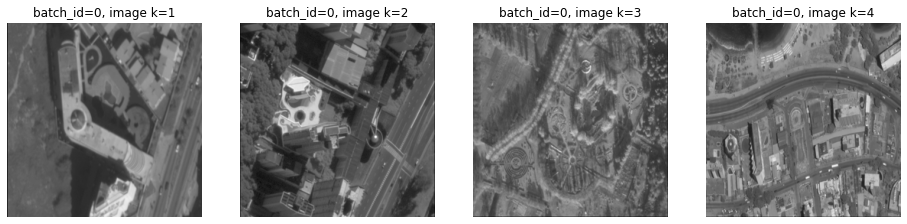

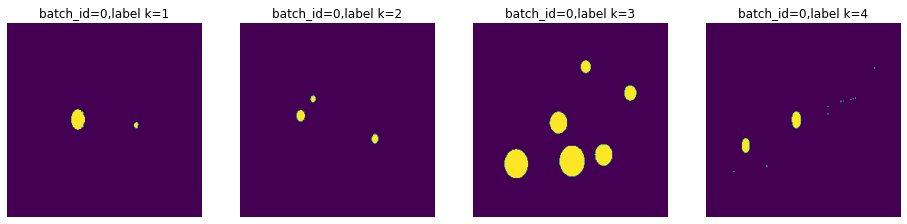

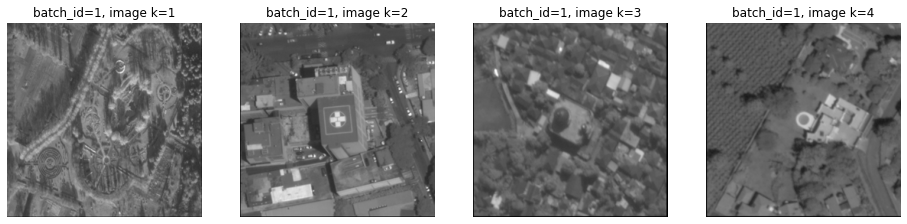

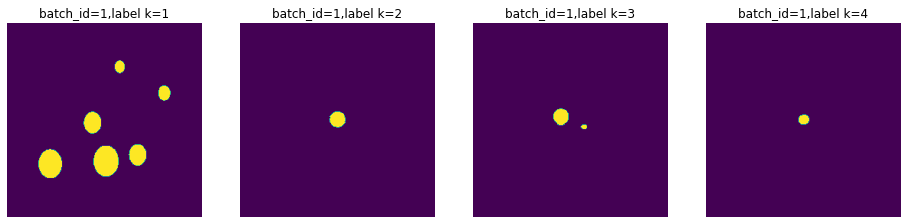

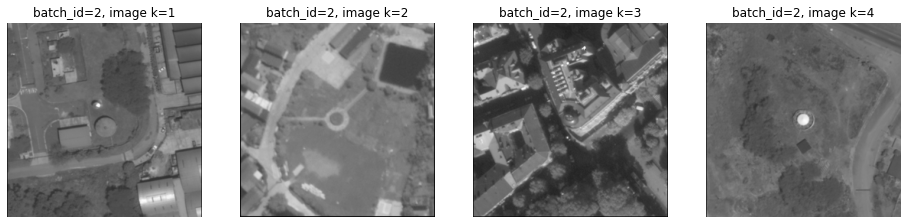

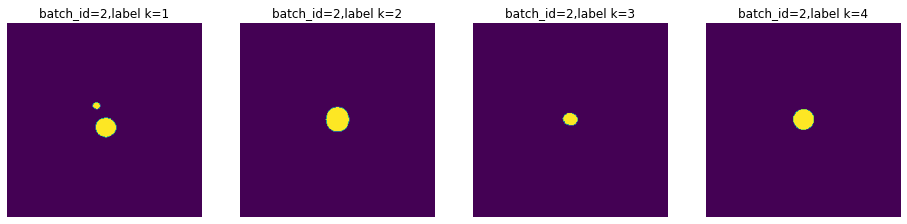

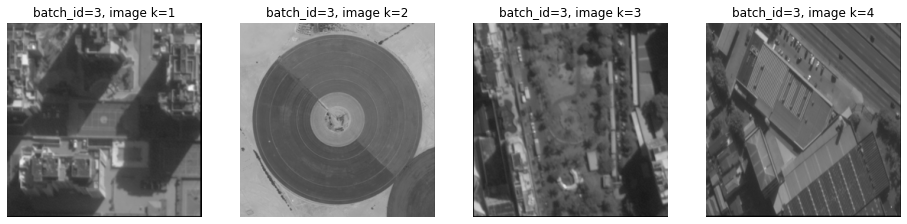

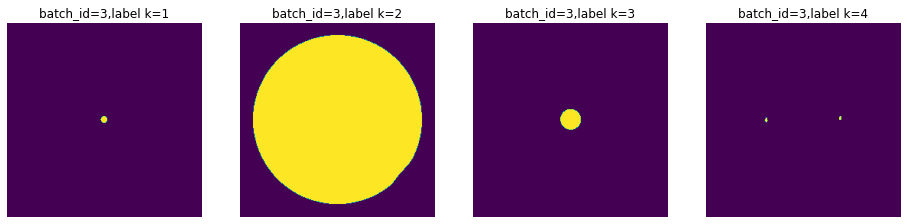

In [15]:
batch_id = random.randint(0,15)
num_samples_per_class = 2*2
num_classes =1
# batch_size = 4
num_meta_test_samples_per_class=3*2

if batch_type == 'meta_test':
    num_samples_per_class = num_meta_test_samples_per_class
    
# plt.figure(figsize=(16,16))

for b in range(batch_size):
    plt.figure(figsize=(16,16))
    index=0
    for i in range(num_classes):
        for k in range(num_samples_per_class):
            plt.subplot(num_classes,num_samples_per_class,index+1)
            im = images[b,i,k]
            # label = labels[0,i,k]
            plt.title("batch_id={}, image k={}".format(b,k+1))
            plt.imshow(im)  
            plt.axis('off')
            index+=1
    plt.show()
    plt.figure(figsize=(16,16))
    index = 0
    for i in range(num_classes):
        for k in range(num_samples_per_class):
            plt.subplot(num_classes,num_samples_per_class,index+1)
            # im = images[0,i,k]
            label = labels[b,i,k]
            plt.imshow(label) 
            plt.title("batch_id={},label k={}".format(b,k+1))
            plt.axis('off')
            index+=1
    plt.show()

# Clustered Data Generator (ToDo: Andrew)
Here we will leverage unsupervised clustering to see if it improves few shot segmentation adapting to different geographic regions

This will be done by rather than assigning examples uniformly random, we will divide clusters at random into meta-train, meta-val, and meta-test